# Проект рекомендация тарифов
Проект по машинному обучению

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. 

Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

Задача: При небольшом выборе пользователей данных определить наиболее выгодный тариф.

## Шаг первый
Изучение представленных данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
%matplotlib inline
from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
test_mode = False # если нужно пропустить построение графиков, не влияющий на датафрейм

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 100)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Два знака после запятой
pd.set_option('display.float_format', '{:.2f}'.format)

C:\Users\msit\AppData\Local\Temp\ipykernel_1580\4233585062.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv') # , sep='\t')
except:
    data = pd.read_csv(r'\Users\msit\Desktop\data science\datasets\users_behavior.csv') #, sep='\t')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0


In [3]:
display('Размер датафрейма: {}'.format(data.shape))
display(data.head())
display(data.tail())
display(data.describe())
start_info = data.info()
display(start_info)

'Размер датафрейма: (3214, 5)'

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
3209,122.00,910.98,20.00,35124.90,1
3210,25.00,190.36,0.00,3275.61,0
3211,97.00,634.44,70.00,13974.06,0
3212,64.00,462.32,90.00,31239.78,0
3213,80.00,566.09,6.00,29480.52,1


,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

In [4]:
data.duplicated().sum()

0

In [5]:
pd.DataFrame({'Features':data.isnull().sum().index,
              'Количество пропущенных данных':data.isnull().sum().values,
              '% пропусков': np.round(data.isnull().sum().values / len(data) *100, 1)}).set_index('Features')

,Количество пропущенных данных,% пропусков
Features,,
calls,0,0.00
minutes,0,0.00
messages,0,0.00
mb_used,0,0.00
is_ultra,0,0.00


In [6]:
profile = ProfileReport(data, title='Общий портрет датасета')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
data.skew() # функция используется для проверки асимметрии данных

calls      0.61
minutes    0.61
messages   1.30
mb_used    0.43
is_ultra   0.84
dtype: float64

Коэффицие́нт асимметри́и (skewness) — числовая характеризующая степени несимметричности распределения данной случайной величины.
Из данных видно,что их распределение не симмитрично. В данном случае в мои задачи не входит исправление, поэтому оставлю все как есть.

Проверим распределение целевого признака

In [8]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [9]:
part = data['is_ultra'].value_counts()[1] / data['is_ultra'].value_counts()[0]
print(f'Доля положительного целевого признака в выборке {part:.2%}')

Доля положительного целевого признака в выборке 44.19%


Итоги:

Доля положительного целевого признака в выборке 44.19 %.

Наблюдаем неравномерное распределение целевого признака. 

Считаю данную неравномерность некритичной для возможности решения задачи проекта.

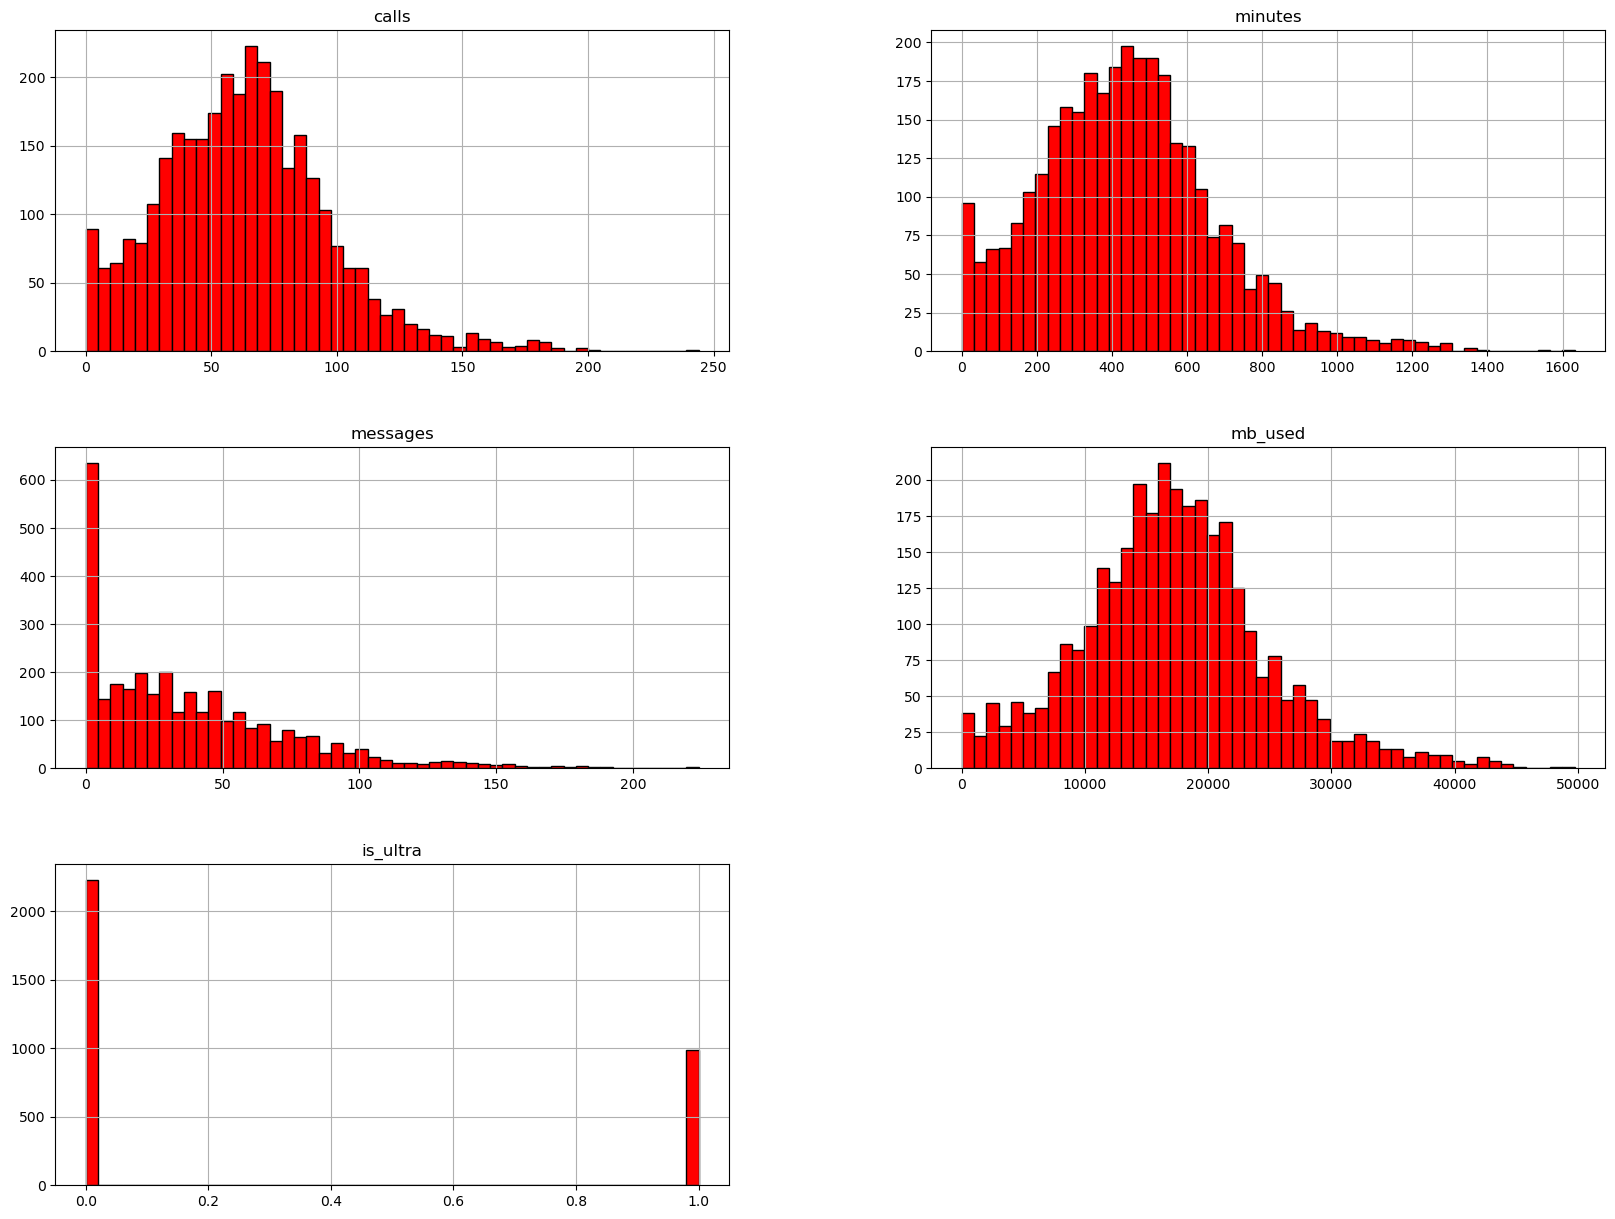

In [10]:
data.hist(bins=50, figsize=(20,15), color='r', edgecolor='black', linewidth=1)
plt.show()

<AxesSubplot:>

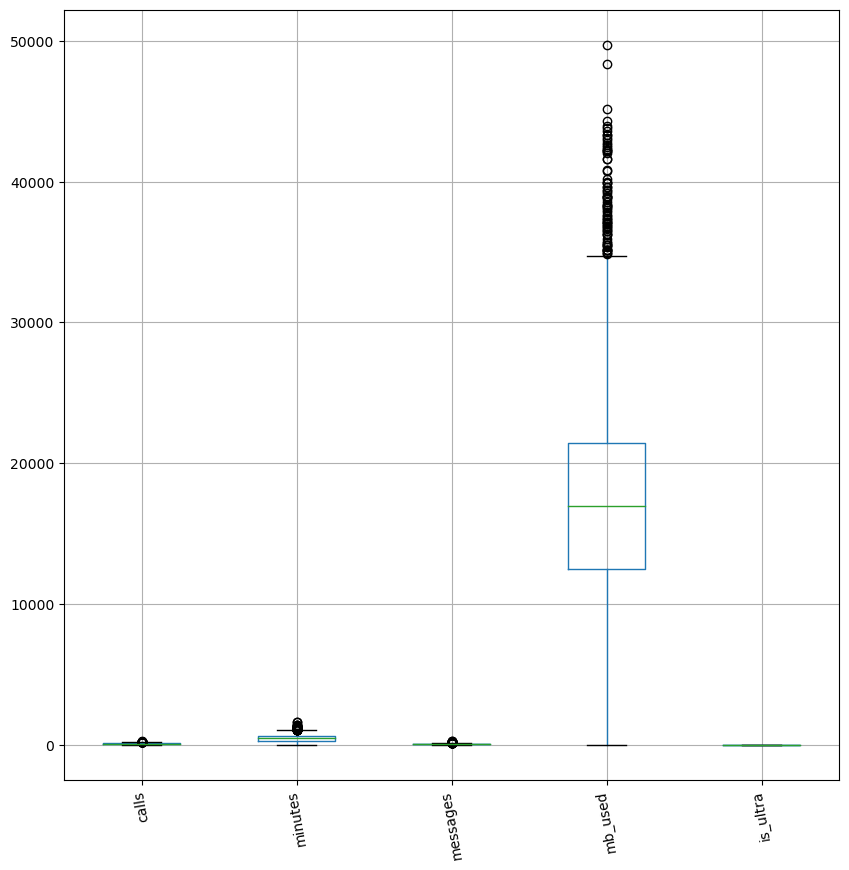

In [11]:
data.boxplot(rot = 100, figsize=(10, 10))

C:\Users\msit\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


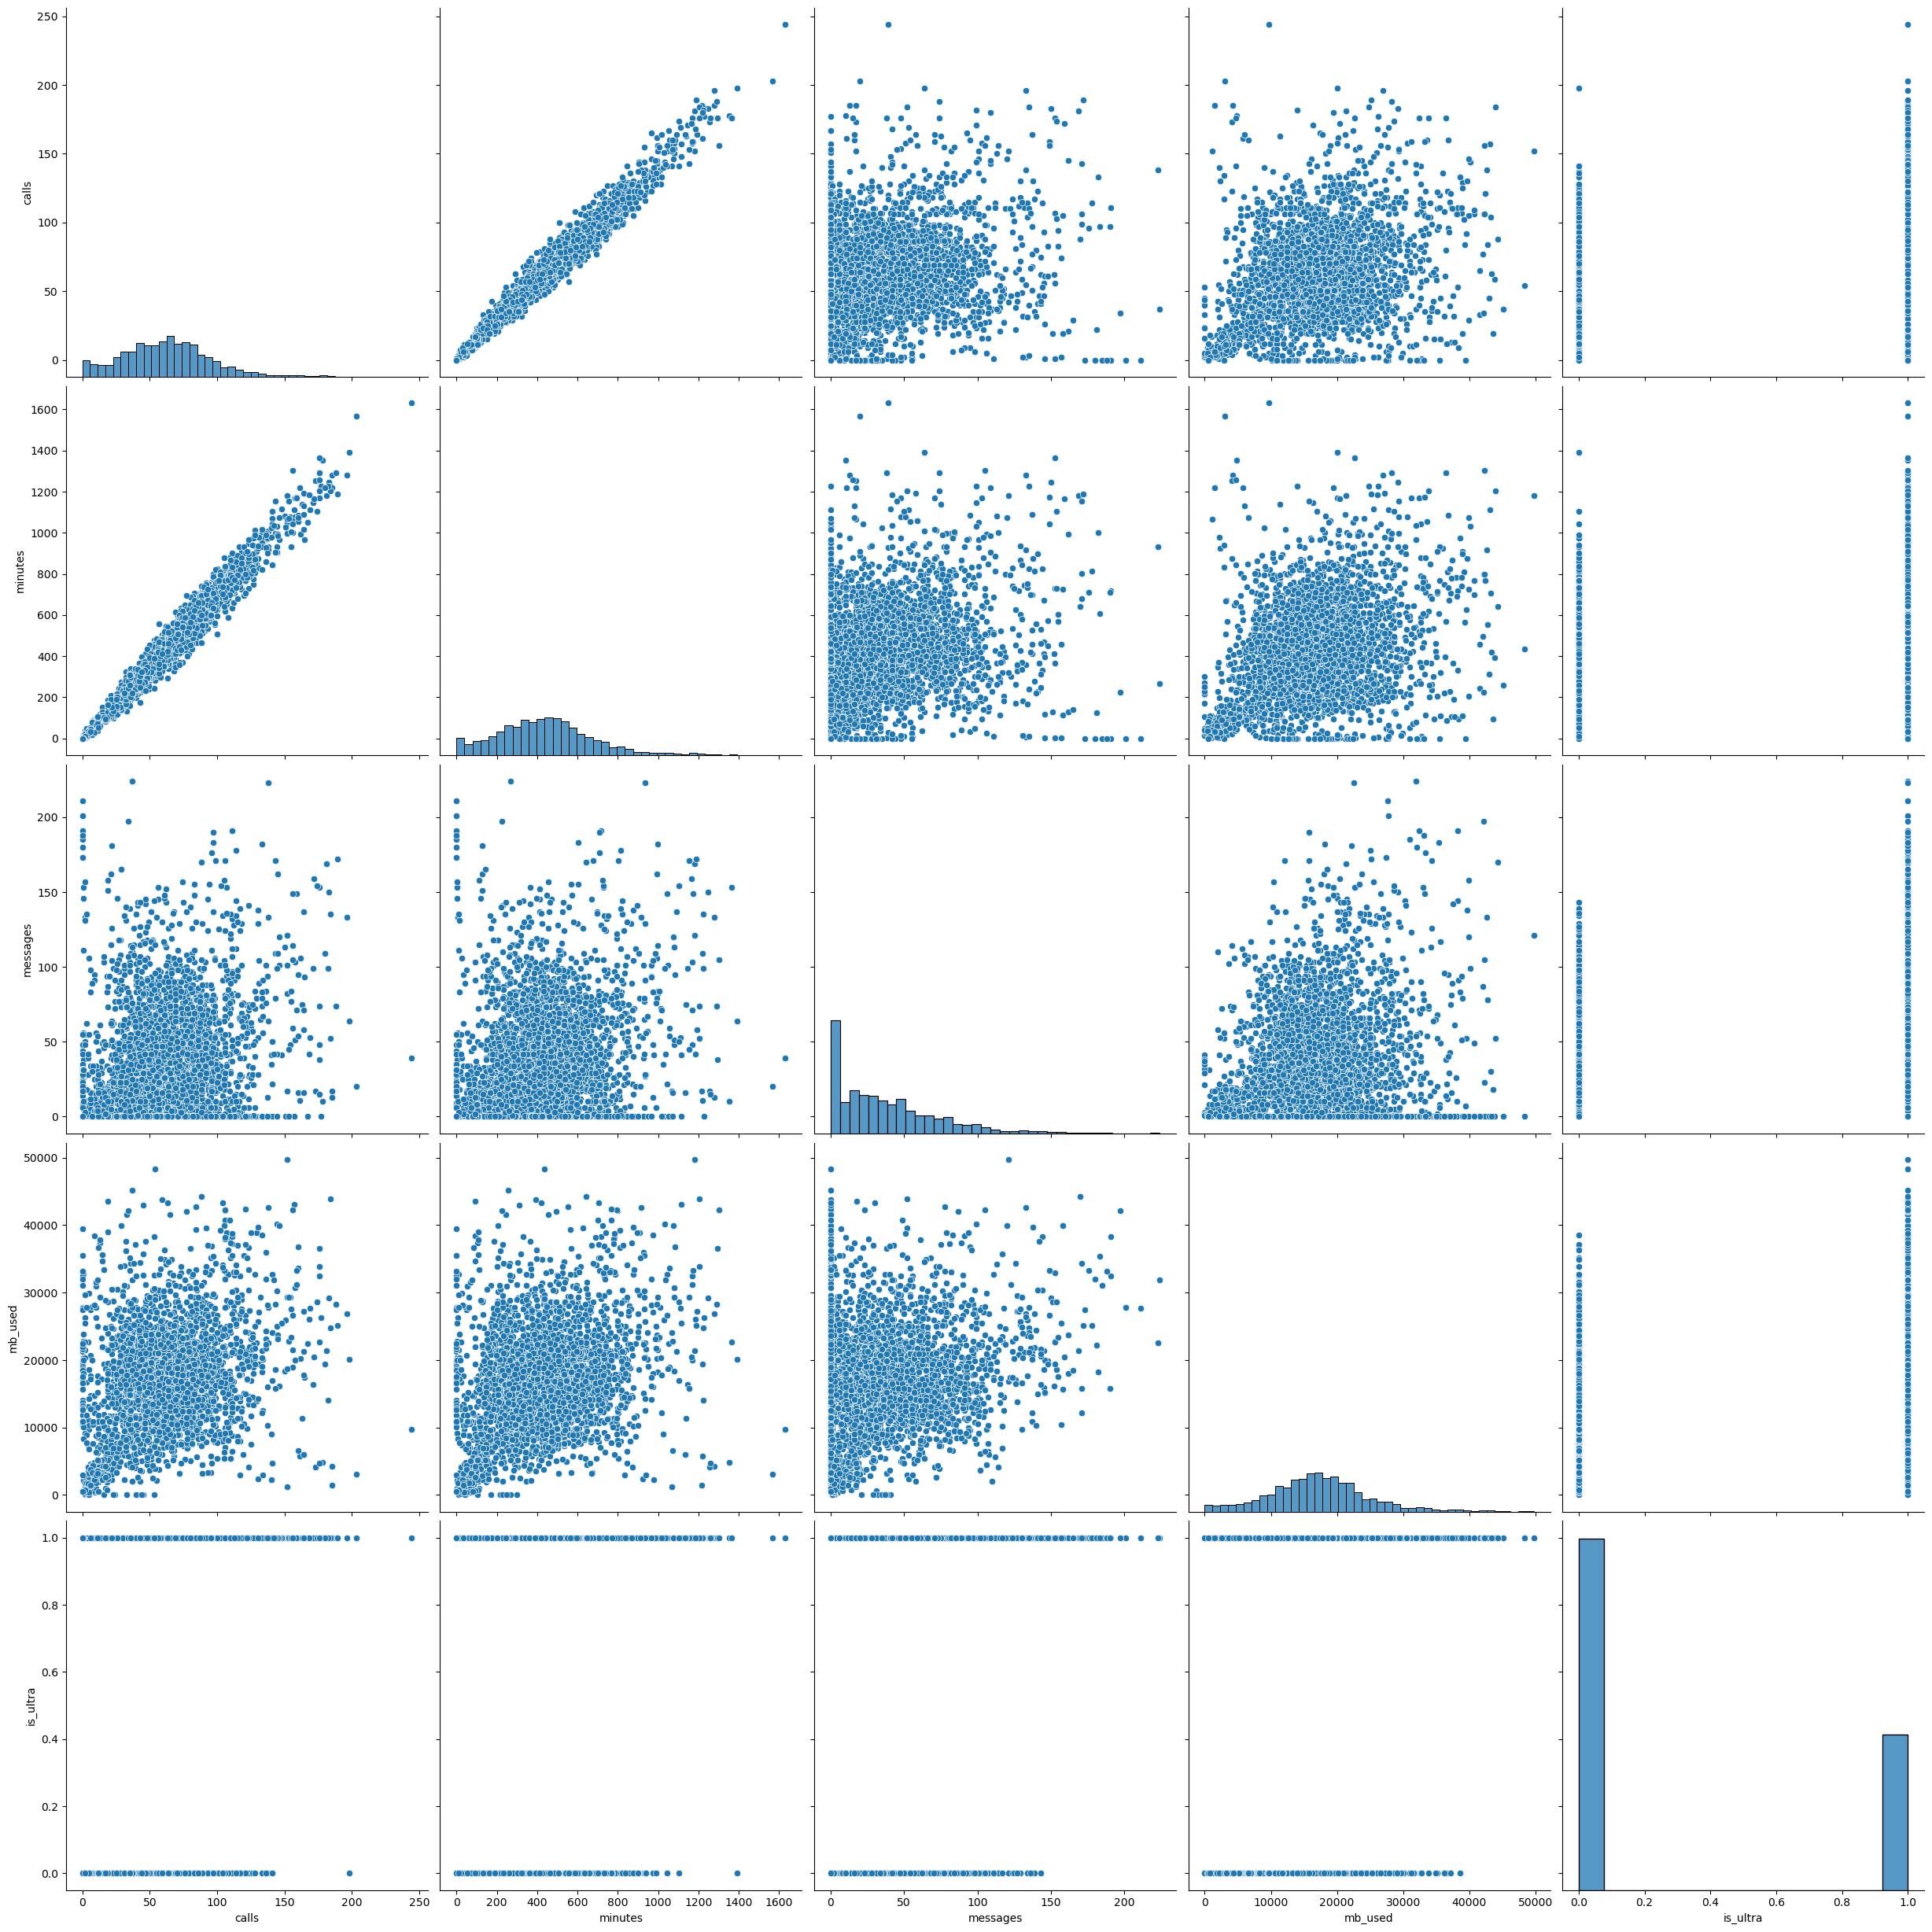

In [12]:
sns.pairplot(data, size=5);

Данные получены и изучены. 

Перед нами стоит задача классификации. За целевой признак берем столбец is_ultra. Остальные признаки помогут нам предсказывать решение по столбцу is_ultra.

## Шаг второй

Так как предобработка данных нам в данном проекте не требуется, то переходим сразу к построению выборок для моделей.

Нормализация и стандартизация также в нашем проекте не требуются.

Сначала разбиваем данные на три выборки: обучающая (60%), валидационная (20%) и тестовая (также 20%).

In [13]:
train_data, vnt_data = train_test_split(data, test_size=0.40, random_state=23042020)
valid_data, test_data = train_test_split(vnt_data, test_size=0.50, random_state=23042020)

print('Обучающая выборка', train_data.shape[0])
print('Валидационная выборка', valid_data.shape[0])
print('Тестовая выборка', test_data.shape[0])

Обучающая выборка 1928
Валидационная выборка 643
Тестовая выборка 643


Составим таблицы признаков для каждой выборки

In [14]:
x = train_data.drop(['is_ultra'], axis=1)
y = train_data['is_ultra']
valid_x = valid_data.drop(['is_ultra'], axis=1)
valid_y = valid_data['is_ultra']
test_x = test_data.drop(['is_ultra'], axis=1)
test_y = test_data['is_ultra']

In [15]:
# train_data_features = train_data.drop(['is_ultra'], axis=1)
# train_data_target = train_data['is_ultra']
# valid_data_features = valid_data.drop(['is_ultra'], axis=1)
# valid_data_target = valid_data['is_ultra']
# test_data_features = test_data.drop(['is_ultra'], axis=1)
# test_data_target = test_data['is_ultra']

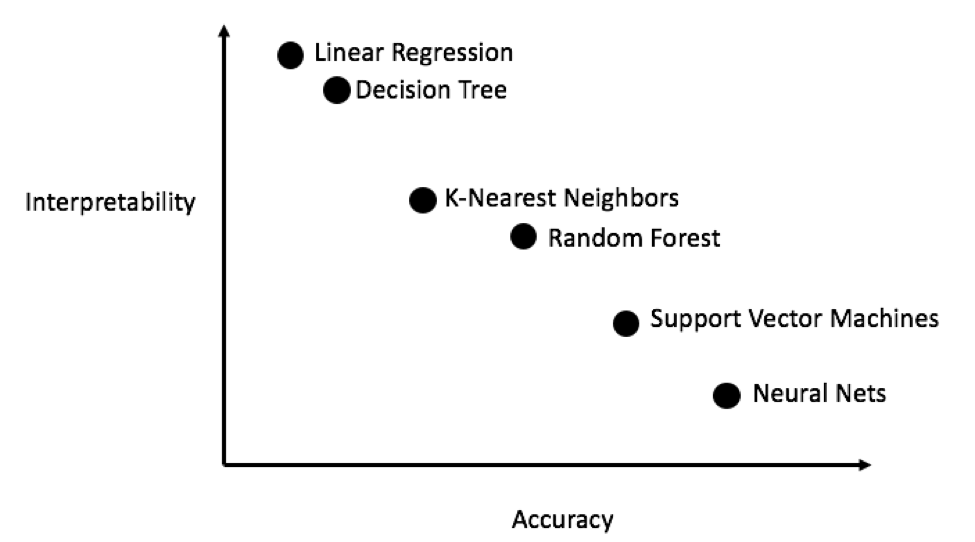

https://blog.fastforwardlabs.com/2017/09/01/why-your-relationship-is-likely-to-last-or-not-using-local-interpretable-model-agnostic-explanations-lime.html

Картинка выше взята отсюда. 

При обучении мы использовали линейную регрессию, случайный лес в регрессии и дерево решений в регрессии.



Соответственно, эти методы машинного обучения я и буду использовать в проекте. 

И попробую на всякий случай использовать нейросети, ведь они должны показывать самую высокую точность, не смотря на то, что проектом их использование не предусмотрено.

In [16]:
import random
rnd_state = 12345
np.random.seed(rnd_state)
random.seed(rnd_state)

## Шаг третий

Построение моделей

Начнем с Дерева выбора

In [17]:
%%time
best_depth = 0
best_accuracy = 0

for depth in range(1,30):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    print('Глубина дерева', depth,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy
print("max_depth =", depth, 'Лучшая глубина дерева', best_depth,'Лучшая точность', best_accuracy)

  

Глубина дерева 1 Точность 0.7527216174183515
Глубина дерева 2 Точность 0.7853810264385692
Глубина дерева 3 Точность 0.7931570762052877
Глубина дерева 4 Точность 0.7884914463452566
Глубина дерева 5 Точность 0.8009331259720062
Глубина дерева 6 Точность 0.807153965785381
Глубина дерева 7 Точность 0.807153965785381
Глубина дерева 8 Точность 0.8149300155520995
Глубина дерева 9 Точность 0.8102643856920684
Глубина дерева 10 Точность 0.7947122861586314
Глубина дерева 11 Точность 0.7916018662519441
Глубина дерева 12 Точность 0.7838258164852255
Глубина дерева 13 Точность 0.7822706065318819
Глубина дерева 14 Точность 0.7667185069984448
Глубина дерева 15 Точность 0.7620528771384136
Глубина дерева 16 Точность 0.7620528771384136
Глубина дерева 17 Точность 0.7589424572317263
Глубина дерева 18 Точность 0.7620528771384136
Глубина дерева 19 Точность 0.749611197511664
Глубина дерева 20 Точность 0.7589424572317263
Глубина дерева 21 Точность 0.7433903576982893
Глубина дерева 22 Точность 0.7418351477449455


Изменим количество используемых деревьев на 9, раз лучший результат у нас показало 8-е.

In [18]:
%%time
best_tree_model = DecisionTreeClassifier(max_depth=9)
best_tree_model.fit(x, y)
valid_predictions = best_tree_model.predict(valid_x)
accuracy = accuracy_score(valid_y, valid_predictions)
print('Точность',accuracy)

Точность 0.8102643856920684
Wall time: 8.98 ms


Попробуем изменить гиперпараметры и использовать критерий "джини".

In [19]:
%%time
best_tree_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, 
            splitter='best')
best_tree_model.fit(x, y)
valid_predictions = best_tree_model.predict(valid_x)
accuracy = accuracy_score(valid_y, valid_predictions)
print('Точность',accuracy)

Точность 0.8164852255054432
Wall time: 13 ms


Теперь используем критерий "энтропия"

In [20]:
%%time
best_tree_model = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, 
            splitter='best')
best_tree_model.fit(x, y)
valid_predictions = best_tree_model.predict(valid_x)
accuracy = accuracy_score(valid_y, valid_predictions)
print('Точность',accuracy)

Точность 0.7869362363919129
Wall time: 13 ms


Лучше всего себя показал критерий "джини" и 9 используемых деревьев. Попробуем изменить splitter на случайный при тех же гипермараметрах

In [21]:
%%time
best_tree_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, 
            splitter='random')
best_tree_model.fit(x, y)
valid_predictions = best_tree_model.predict(valid_x)
accuracy = accuracy_score(valid_y, valid_predictions)
print('Точность',accuracy)

Точность 0.7978227060653188
Wall time: 5.98 ms


Раньше было лучше. Оставим best

Перейдем к случайному лесу

In [22]:
%%time
best_estim = 0
best_accuracy = 0

for estim in range(1,50):
    best_forest_model = RandomForestClassifier(n_estimators=estim)
    best_forest_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    print('Количество деревьев', estim,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_estim = estim
        best_accuracy = accuracy

print('Лучшее количество деревьев', best_estim,'Лучшая точность', best_accuracy) 

Количество деревьев 1 Точность 0.7387247278382582
Количество деревьев 2 Точность 0.7387247278382582
Количество деревьев 3 Точность 0.7387247278382582
Количество деревьев 4 Точность 0.7387247278382582
Количество деревьев 5 Точность 0.7387247278382582
Количество деревьев 6 Точность 0.7387247278382582
Количество деревьев 7 Точность 0.7387247278382582
Количество деревьев 8 Точность 0.7387247278382582
Количество деревьев 9 Точность 0.7387247278382582
Количество деревьев 10 Точность 0.7387247278382582
Количество деревьев 11 Точность 0.7387247278382582
Количество деревьев 12 Точность 0.7387247278382582
Количество деревьев 13 Точность 0.7387247278382582
Количество деревьев 14 Точность 0.7387247278382582
Количество деревьев 15 Точность 0.7387247278382582
Количество деревьев 16 Точность 0.7387247278382582
Количество деревьев 17 Точность 0.7387247278382582
Количество деревьев 18 Точность 0.7387247278382582
Количество деревьев 19 Точность 0.7387247278382582
Количество деревьев 20 Точность 0.738724

Применим критерий "Энтропия"

In [23]:
%%time
for estim in range(1,40):
    best_forest_model = RandomForestClassifier(class_weight=None, criterion='entropy', 
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, 
            )
    best_forest_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    print('Количество деревьев', estim,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_estim = estim
        best_accuracy = accuracy

print('Лучшее количество деревьев', best_estim,'Лучшая точность', best_accuracy) 

Количество деревьев 1 Точность 0.7387247278382582
Количество деревьев 2 Точность 0.7387247278382582
Количество деревьев 3 Точность 0.7387247278382582
Количество деревьев 4 Точность 0.7387247278382582
Количество деревьев 5 Точность 0.7387247278382582
Количество деревьев 6 Точность 0.7387247278382582
Количество деревьев 7 Точность 0.7387247278382582
Количество деревьев 8 Точность 0.7387247278382582
Количество деревьев 9 Точность 0.7387247278382582
Количество деревьев 10 Точность 0.7387247278382582
Количество деревьев 11 Точность 0.7387247278382582
Количество деревьев 12 Точность 0.7387247278382582
Количество деревьев 13 Точность 0.7387247278382582
Количество деревьев 14 Точность 0.7387247278382582
Количество деревьев 15 Точность 0.7387247278382582
Количество деревьев 16 Точность 0.7387247278382582
Количество деревьев 17 Точность 0.7387247278382582
Количество деревьев 18 Точность 0.7387247278382582
Количество деревьев 19 Точность 0.7387247278382582
Количество деревьев 20 Точность 0.738724

Применим критерий "джини"

In [24]:
%%time
for estim in range(1,30):
    best_forest_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, 
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, 
                       verbose=0, warm_start=False)
    best_forest_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    
    if accuracy > best_accuracy:
        best_estim = estim
        best_accuracy = accuracy

print('Лучшее количество деревьев', best_estim,'Лучшая точность', best_accuracy) 

Лучшее количество деревьев 1 Лучшая точность 0.7387247278382582
Wall time: 9.38 s


Результат у метода случайного леса при изменении гиперпараметров получается одинаковый.

In [25]:
best_forest_model = RandomForestClassifier(random_state=23042020, n_estimators=18, warm_start=True)
best_forest_model.fit(x, y)
valid_predictions = model.predict(valid_x)
accuracy = accuracy_score(valid_y, valid_predictions)
print('Количество деревьев', estim,'Точность',accuracy)

Количество деревьев 29 Точность 0.7387247278382582


Перейдем к логистической регрессии. 

In [26]:
%%time
best_max_iter = 0
best_accuracy = 0

for max_iter in range(1, 10):
    best_reg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
    best_reg_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    print('Количество итерраций', max_iter,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_max_iter = max_iter
        best_accuracy = accuracy

print('Лучшая количество итерраций', best_max_iter,'Лучшая точность', best_accuracy)   

Количество итерраций 1 Точность 0.7387247278382582
Количество итерраций 2 Точность 0.7387247278382582
Количество итерраций 3 Точность 0.7387247278382582
Количество итерраций 4 Точность 0.7387247278382582
Количество итерраций 5 Точность 0.7387247278382582
Количество итерраций 6 Точность 0.7387247278382582
Количество итерраций 7 Точность 0.7387247278382582
Количество итерраций 8 Точность 0.7387247278382582
Количество итерраций 9 Точность 0.7387247278382582
Лучшая количество итерраций 1 Лучшая точность 0.7387247278382582
Wall time: 395 ms


In [27]:
%%time
from joblib import dump
best_reg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
best_reg_model.fit(x, y)
dump(model, 'model_9_1.joblib')
print('Лучшая количество итерраций', best_max_iter,'Лучшая точность', best_accuracy)   

Лучшая количество итерраций 1 Лучшая точность 0.7387247278382582
Wall time: 34.6 ms


In [28]:
%%time

best_solver = ''
best_accuracy = 0

for solve in {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}:
    best_reg_model = LogisticRegression(random_state=23042020, solver=solve)
    best_reg_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    print('Solver', solve,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_solver= solve
        best_accuracy = accuracy

print('Лучший solver', best_solver,'Лучшая точность', best_accuracy) 

Solver liblinear Точность 0.7387247278382582
Solver sag Точность 0.7387247278382582
Solver lbfgs Точность 0.7387247278382582
Solver saga Точность 0.7387247278382582
Solver newton-cg Точность 0.7387247278382582
Лучший solver liblinear Лучшая точность 0.7387247278382582
Wall time: 190 ms


C:\Users\msit\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\msit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\msit\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\msit\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not con

In [29]:
%%time

best_C = 0.0
best_accuracy = 0

for float_c in [x/10 for x in range(1,21)]:
    best_reg_model = LogisticRegression(random_state=23042020, C=float_c)
    best_reg_model.fit(x, y)
    valid_predictions = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, valid_predictions)
    
    if accuracy > best_accuracy:
        best_C= float_c
        best_accuracy = accuracy

print('Лучший C', best_C,'Лучшая точность', best_accuracy) 

C:\Users\msit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\msit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Лучший C 0.1 Лучшая точность 0.7387247278382582
Wall time: 590 ms


### Вывод по шагу 3

- Лучше всего себя показало дерево решений Точность 0.8164852255054432 с критерием "джини", сплиттером best  и использованием 9 шагов. Так как у нас набор данных сранвительно небольшой, то 9 шагов обоснованно.
- На втором месте метод случайного леса с 30 шагами и также критерием "джини" с точностью 0.8149300155520995
- Логистическая регрессия показала себя хуже всего, выдав точность на уровне 0.7667185069984448

В задании проекта требовалась точность не ниже 0,75. Соответственно, все три модели с заданием справились.

Теперь необходимо проверить точность на тестовой выборке.

In [30]:
test_predictions = best_tree_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
print('Точность модели дерева решений на тестовой выборке',accuracy)

test_predictions = best_forest_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
print('Точность модели случайного леса на тестовой выборке',accuracy)

test_predictions = best_reg_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
print('Точность модели логистической регресиии на тестовой выборке',accuracy)

Точность модели дерева решений на тестовой выборке 0.7682737169517885
Точность модели случайного леса на тестовой выборке 0.7822706065318819
Точность модели логистической регресиии на тестовой выборке 0.7153965785381027


### Вывод по шагу 4

Для решения поставленной задачи можно выбрать модель случайного леса, так как показатели  точности выше требуемых.

Также рекомендую использовать метод дерева решений, так как данный метод также показывает результаты лучше требуемых и при этом использует меньше времени на операцию.


## Шаг 5

Проверьте модели на адекватность

Адекватность модели оценивается по нескольким параметрам. Для модели классификации это accuracy, precision и recall. Качество модели лучше всего отражают precision и recall и эти метрики складываются в F-мера как единую оценку модели.

In [31]:
test_predictions = best_forest_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
precision = precision_score(test_y, test_predictions)
recall = recall_score(test_y, test_predictions)
print('Точность модели случайного леса =', accuracy, 
      'Положительная прогностическая ценность =', 
      precision, 'Чувствительность =', recall)

Точность модели случайного леса = 0.7822706065318819 Положительная прогностическая ценность = 0.7430555555555556 Чувствительность = 0.5095238095238095


In [32]:
f_score = f1_score(test_y, test_predictions)
print('F-мера метода случайного леса =', f_score)

F-мера метода случайного леса = 0.6045197740112994


In [33]:
test_predictions = best_tree_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
precision = precision_score(test_y, test_predictions)
recall = recall_score(test_y, test_predictions)
print('Точность модели дерева решений =', accuracy, 
      'Положительная прогностическая ценность =', 
      precision, 'Чувствительность =', recall)

Точность модели дерева решений = 0.7682737169517885 Положительная прогностическая ценность = 0.7699115044247787 Чувствительность = 0.4142857142857143


In [34]:
f_score = f1_score(test_y, test_predictions)
print('F-мера метода дерева решений =', f_score)

F-мера метода дерева решений = 0.5386996904024768


In [35]:
test_predictions = best_reg_model.predict(test_x)
accuracy = accuracy_score(test_y, test_predictions)
precision = precision_score(test_y, test_predictions)
recall = recall_score(test_y, test_predictions)
print('Точность модели логистической регрессии =', accuracy, 
      'Положительная прогностическая ценность =', 
      precision, 'Чувствительность =', recall)

Точность модели логистической регрессии = 0.7153965785381027 Положительная прогностическая ценность = 0.7755102040816326 Чувствительность = 0.18095238095238095


In [36]:
f_score = f1_score(test_y, test_predictions)
print('F-мера метода логистической регресии =', f_score)

F-мера метода логистической регресии = 0.2934362934362934


### Вывод по шагу 5 

Тест на вменяемость лучше всего прошел метод случайного леса.

# Бонус

Так как проектом не предусмотрено изучение методов градиентного бустинга и нейросетей, а на картинке выше они были представлены, то я все-таки решила попробовать их использовать и посмотреть, какие результаты покажут модели.

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model
gradient_boosted = GradientBoostingRegressor()

# Fit the model on the training data
gradient_boosted.fit(x, y)

# Make predictions on the test data
predictions = gradient_boosted.predict(valid_x)

# Evaluate the model
mae = np.mean(abs(predictions - valid_y))

print('Тест МАЕ в градиентном бустинге: MAE = %0.4f' % mae)
# Чем ниже МАЕ, тем выше точность предсказания.

Тест МАЕ в градиентном бустинге: MAE = 0.2830


In [38]:
%%time
from sklearn.model_selection import KFold,cross_val_score

kf = KFold(n_splits =20, shuffle = True) 
GBoost_model = GradientBoostingRegressor(n_estimators=500,
          max_depth=12,
          learning_rate=0.03,
          min_samples_leaf=16,
          min_samples_split=16)
GBoost_model.fit(x, y)
scores = cross_val_score(GBoost_model,valid_x, valid_y, scoring="neg_mean_squared_error", cv = kf)   
scores = np.sqrt(-scores)
print(scores)


[0.41060249 0.35559656 0.31340565 0.49433345 0.49877686 0.41749433
 0.39617456 0.3822161  0.39763003 0.37072868 0.4610135  0.48794882
 0.51207801 0.38249275 0.46144178 0.42031072 0.42125092 0.35265081
 0.40243262 0.40314317]
Wall time: 16.4 s


In [39]:
train_accuracy_score=GBoost_model.score(x, y)
print(train_accuracy_score)

0.7640979105525821


При подборе гипермараметров данный метод также показывает хорошие результаты качества модели.

In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
 
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.utils import validation
from keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
model = keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="linear"),
        layers.Dense(1)
    ]
)

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])

net = model.fit(x, y, epochs=30, validation_data = (valid_x, valid_y),
                    verbose = 1)


Epoch 1/30
61/61 [==============================] - 1s 4ms/step - loss: 69129.6484 - accuracy: 0.5010 - val_loss: 2375.9434 - val_accuracy: 0.2970
Epoch 2/30
61/61 [==============================] - 0s 2ms/step - loss: 428.9792 - accuracy: 0.4995 - val_loss: 108.6537 - val_accuracy: 0.5210
Epoch 3/30
61/61 [==============================] - 0s 2ms/step - loss: 119.6493 - accuracy: 0.5161 - val_loss: 103.7185 - val_accuracy: 0.6205
Epoch 4/30
61/61 [==============================] - 0s 2ms/step - loss: 96.0466 - accuracy: 0.5239 - val_loss: 76.2572 - val_accuracy: 0.4899
Epoch 5/30
61/61 [==============================] - 0s 2ms/step - loss: 82.4260 - accuracy: 0.5233 - val_loss: 55.7403 - val_accuracy: 0.5770
Epoch 6/30
61/61 [==============================] - 0s 2ms/step - loss: 80.8094 - accuracy: 0.5223 - val_loss: 61.9538 - val_accuracy: 0.6610
Epoch 7/30
61/61 [==============================] - 0s 2ms/step - loss: 60.5925 - accuracy: 0.5233 - val_loss: 33.2793 - val_accuracy: 0.60

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


In [42]:
hist_1 = pd.DataFrame(history.history)
hist_1['epoch'] = history.epoch
hist_1.head(30)

NameError: name 'history' is not defined

In [ ]:
loss, accuracy = model.evaluate(x, y)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

При подборе количества эпох данная модель также может показывать неплохие результаты, но качество не дотягивает до требуемых 0,75

# Общий вывод по проекту

Машинное обучение - технология, которая строит саму себя. Это новое явление в нашем мире. Во второй половине ХХ века машинное обучение развилось в подобласть искусственного интеллекта, которая охватывала разработку самообучающихся алгоритмов. Эти алгоритмы разрабатываются с целью обработки данных и выполнения различных прогнозов более простыми способами чем построение модели в ручном режиме.

Полезнее рассматривать машинное обучение как средство созданий моделей данных. Создается математическая модель для исследования данных с последующим постепенным улучшение качества прогнозных моделей и принятие решений, управляемых данными. 

Задачи «обучения» начинаются с появлением у этих моделей настраиваемых параметров, которые можно приспособить для отражения наблюдаемых данных, таким образом, программа обучается на данных.

Наиболее успешные алгоритмы машинного обучения являются те, которые автоматизируют процессы принятия решений путем обобщения известных примеров. В этих методах, пользователь предоставляет алгоритму пары объект-ответ, а алгоритм находит способ получения ответа по объекту. В частности, алгоритм способен выдать ответ для объекта, которого он никогда не видел раньше, без какой-либо помощи.

Каждый год в мире появляются сотни новых алгоритмов с обучением, но все они основаны на небольшом наборе фундаментальных идей.


В ходе проделанной работы было выполнено:

1. Изучен файл с данными.
2. Разбиты данные на три выборки: обучающая, валидационная и тестовая.
3. Исследованы три модели классификации: Решающее дерево, Случайный лес и Логистическая регрессия.
4. Найдены оптимальные параметры для каждой модели и выбрана одна из них для обучения модели.
5. Оценена точность обученной модели.
6. Оценена адекватность модели.
7. Также дополнительно взяты модели классификации - градиентный бустинг и нейронные сети. Градиентный бустинг показывает лучшие результаты на небольшом количестве данных, также, как и предыдущие модели, потому что данный алгоритм строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге собирает одну, но уже более эффективную.


Важно отметить, что используемые алгоритмы классификации напрямую зависят от исходных данных. 

Для обучения модели была использована выборка в 2000 значений. Этого может быть недостаточно для повышения ключевых параметров модели классификатора. Увеличение в 10 или 100 увеличит accuracy, precision и recall, а также время обучения.
